In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
from scipy.constants import speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9
ps = 1e-12

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI ** 2 / meV / c ** 2    

hbar = hbar_meV_ps
m = me

m = m * 0.98 
omega = 1 / hbar
alpha_ent_barr = 0.4900
alpha_ent_exit_barr = 0.0370
alpha_exit_barr = 0.4800
alpha_exit_ent_bar = 0.0520
V_ent = -0.7000
V_exit = -0.7000
V_amp = 1.4150
f = 4
x_ent = 0
x_exit = 100
U_scr = 1
L_ent = 100
L_exit = 100
L_scr = 1

x_min, x_max = -50, 150
t_min, t_max = 0, 7

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead.")

Using cuda


In [4]:
class PINN(nn.Module):
	def __init__(self, layers):
			super(PINN, self).__init__()
			self.hidden_layers = nn.ModuleList()
			
			for units in layers[1:-1]:
					self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
					layers[0] = units
			
			self.output_layer = nn.Linear(layers[-2], layers[-1])

			self.n_collocation = 5000
			self.n_initial = 1000
			self.n_boundary = 500

	def forward(self, inputs):
			x, t = inputs
			X = torch.stack((x, t), dim=1)
			activation_1 = nn.Tanh()
			activation_2 = nn.SiLU()
			i = 1

			for layer in self.hidden_layers:
					X = layer(X)
					X = activation_1(X) if i < 2 else activation_2(X)
					i += 1

			output = self.output_layer(X)
			psi_real = output[:, 0]
			psi_img = output[:, 1]
			
			return psi_real, psi_img
 
	def theta(self, arr):
				return torch.where(arr > 0, 1, 0)
		
	def complex_potential(self, x, t):
			V_ac = V_amp * torch.cos(torch.tensor(2 * torch.pi * f * t * 1e-3, device=device))
			A_ent = -alpha_ent_barr * (V_ent + V_ac)
			B_ent = (alpha_ent_barr / alpha_ent_exit_barr) ** (-torch.abs(x - x_ent) / torch.abs(torch.tensor(x_exit - x_ent, device=device)))
			U_ent = A_ent * B_ent
			
			A_exit = -alpha_exit_barr * V_exit
			B_exit = (alpha_exit_barr / alpha_exit_ent_bar) ** (-torch.abs(x - x_exit) / torch.abs(torch.tensor(x_exit - x_ent, device=device)))
			U_exit = A_exit * B_exit
			
			A_upper = U_scr * torch.exp(-((x - x_ent) / L_scr) * self.theta(x - x_ent)) * torch.exp(-((x_ent - L_ent - x) / L_scr) * self.theta(x_ent - L_ent - x))
			B_upper = U_scr * torch.exp(-((x - x_exit - L_exit) / L_scr) * self.theta(x - x_exit - L_exit)) * torch.exp(-((x_exit - x) / L_scr) * self.theta(x_exit - x))
			U_upper = A_upper + B_upper
			
			return U_ent + U_exit + U_upper

In [5]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [6]:
model = PINN(layers)

In [7]:
model.load_state_dict(torch.load("../results/complex_potential/model_3.pth", map_location=torch.device(device)))		

<All keys matched successfully>

In [8]:
import json

with open("../results/complex_potential/history_3.json", "r") as file:
  history = json.load(file)

epochs = 50000

In [9]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

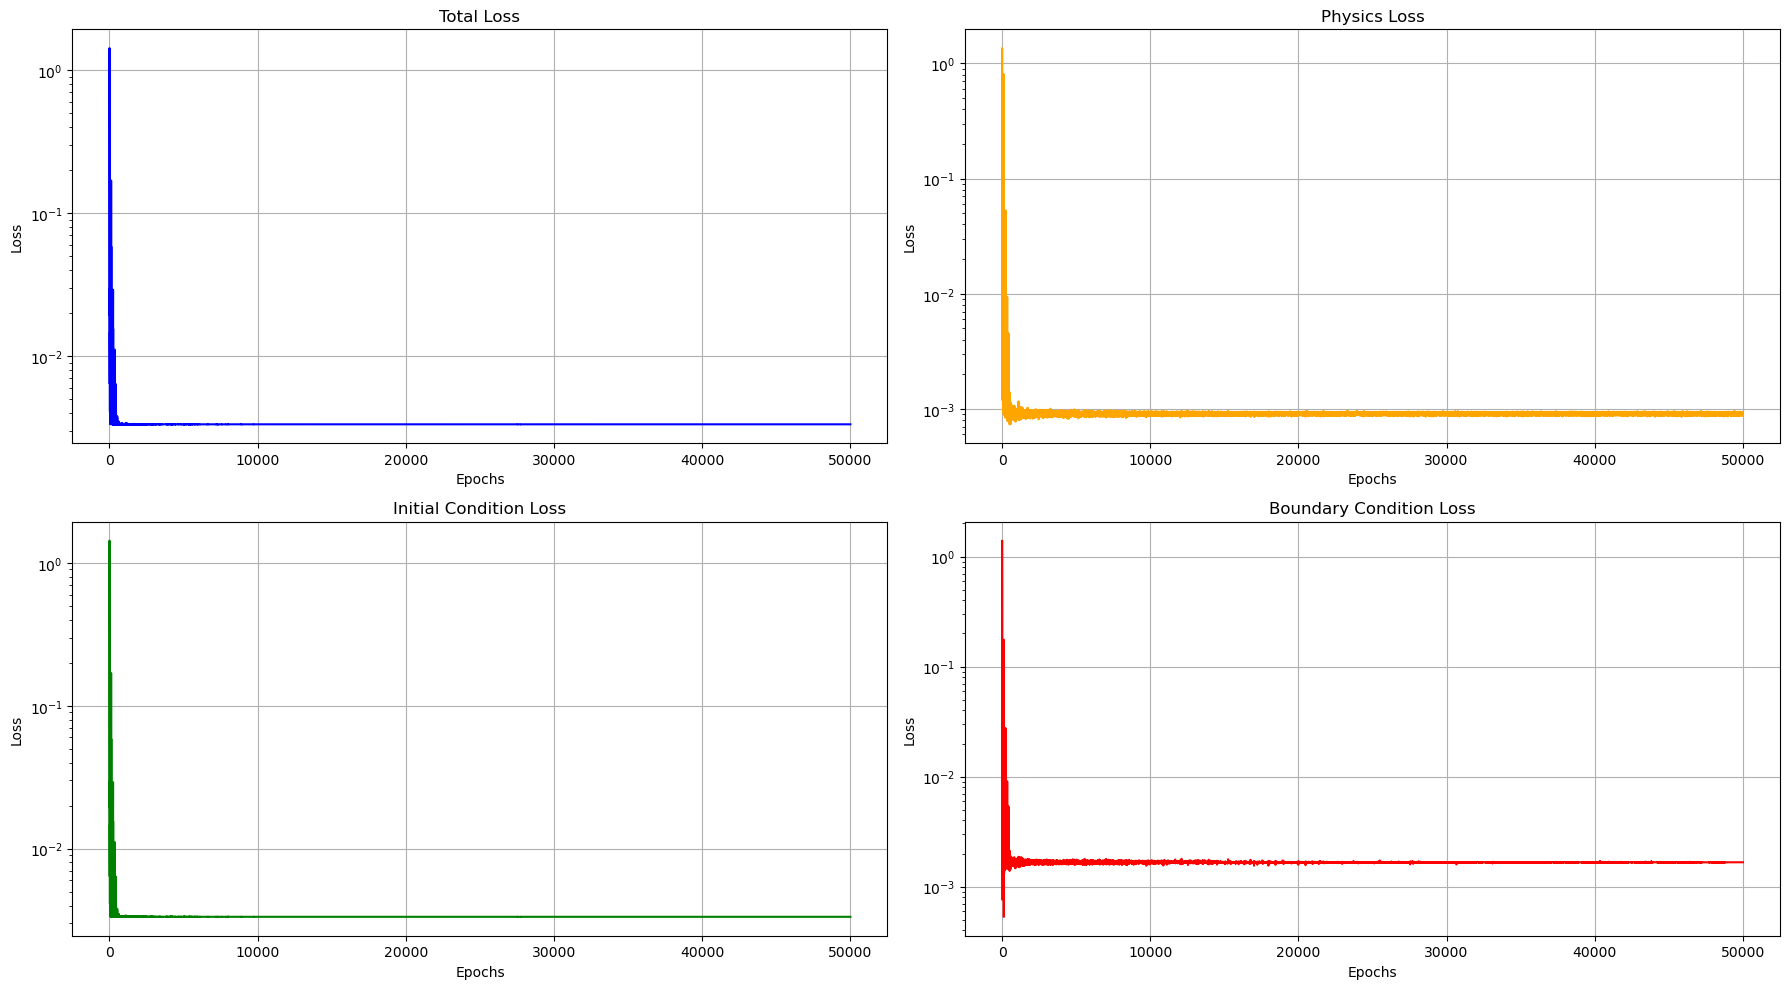

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

In [11]:
# def view_metrics(arr):
#     mean = np.mean(arr)
#     std = np.std(arr)
#     mn = np.min(arr)
#     mx = np.max(arr)
    
#     fig = go.Figure(data=[go.Table(header=dict(values=['Mean', 'Standard Deviation', 'Min', 'Max']),
#                  cells=dict(values=[[f"{mean:.5f}"], [f"{std:.5f}"], [f"{mn:.5f}"], [f"{mx:.5f}"]]))
#                      ])
#     fig.update_layout(width=500, height=300)
#     fig.show()

In [12]:
Nx = 2000
Nt = 2000

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [13]:
# def analytical(x, t):
#     A = (1 / np.sqrt(2)) * ((1 / np.pi) ** 0.25) * np.exp(-(x ** 2) / 2)
#     B1 = np.exp(-1j * 0.5 * t)
#     B2 = np.exp(-1j * 1.5 * t) * np.sqrt(2) * x
#     return A * (B1 + B2)

In [14]:
# psi_real_analytical = np.zeros((Nx, Nt), dtype=np.float64)
# psi_img_analytical = np.zeros((Nx, Nt), dtype=np.float64)

# for i, x in enumerate(x_values):
#     for j, t in enumerate(t_values):
#         psi_x_t = analytical(x, t)

#         psi_real_analytical[i, j] = np.real(psi_x_t)
#         psi_img_analytical[i, j] = np.imag(psi_x_t)

In [15]:
# plt.figure(figsize=(8, 6), dpi=200)
# psi_sq_analytical = psi_real_analytical ** 2 + psi_img_analytical ** 2

# plt.pcolormesh(x_values, t_values, psi_sq_analytical.transpose(), shading="auto")
# plt.colorbar(label='|ψ(x,t)|^2')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Analytical |ψ|^2')
# plt.show()

In [16]:
x_values_torch = torch.from_numpy(x_values).float()
t_values_torch = torch.from_numpy(t_values).float()

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

batch_size = 1000000
psi_real_list = []
psi_img_list = []

model.eval()
with torch.no_grad():
    for i in range(0, x_flat.shape[0], batch_size):
        x_batch = x_flat[i:i+batch_size]
        t_batch = t_flat[i:i+batch_size]
        psi_real, psi_img = model((x_batch, t_batch))
        psi_real_list.append(psi_real.cpu())
        psi_img_list.append(psi_img.cpu())

# psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

# psi_real_pinn = torch.reshape(psi_real_pinn, (Nx, Nt))
# psi_img_pinn = torch.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = torch.cat(psi_real_list).reshape(Nx, Nt).numpy()
psi_img_pinn = torch.cat(psi_img_list).reshape(Nx, Nt).numpy()

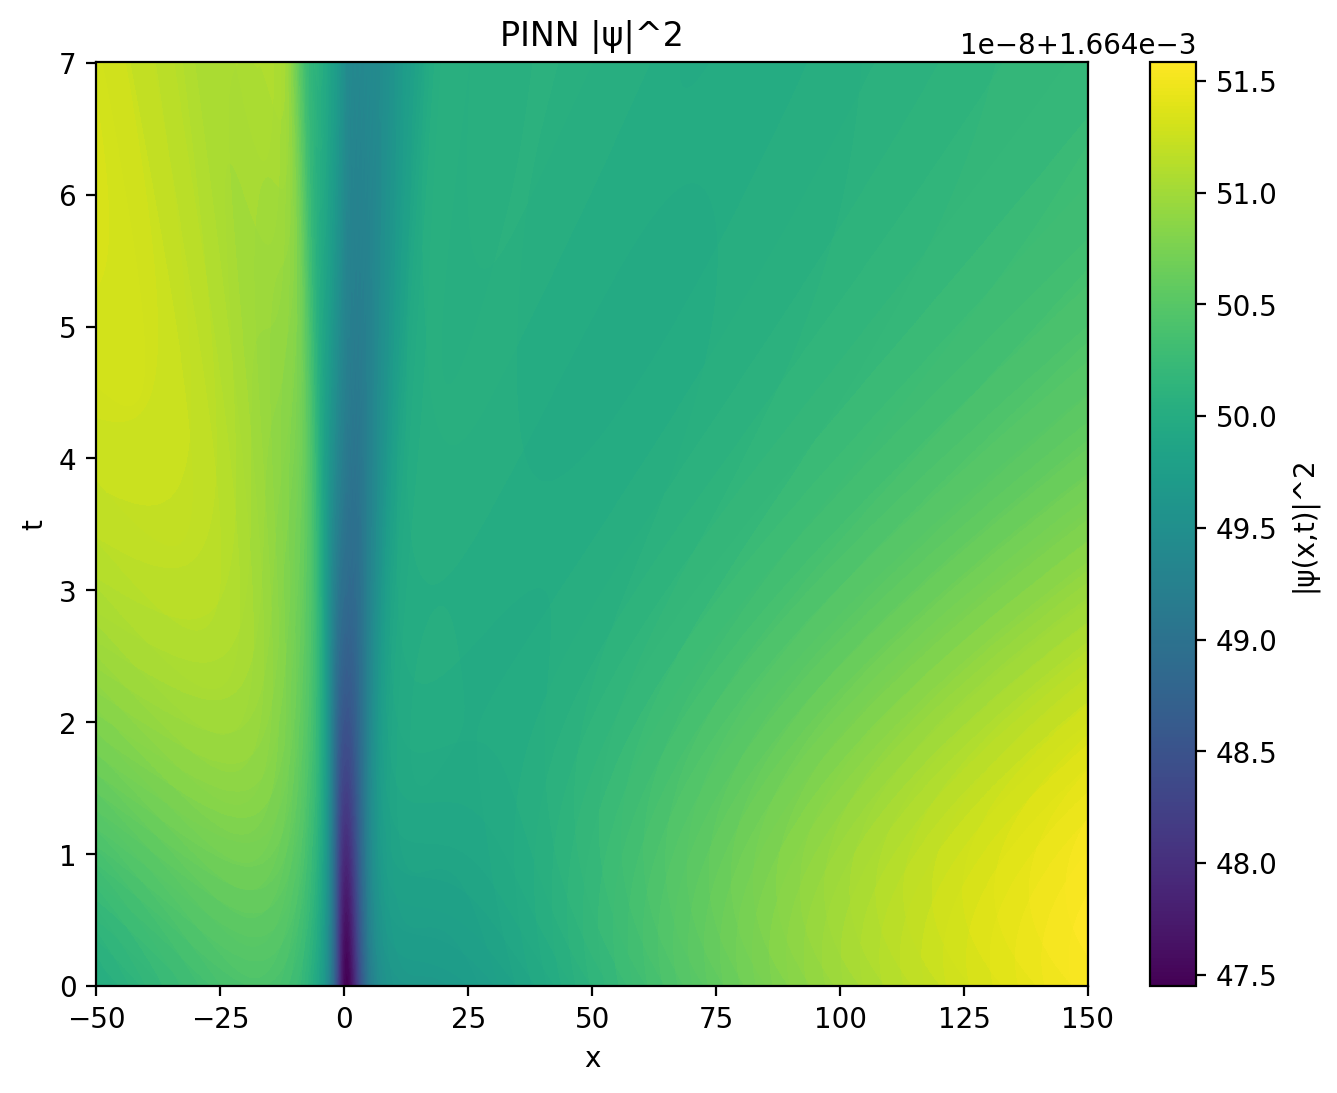

In [17]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq_pinn = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq_pinn.transpose(), shading="auto")
plt.colorbar(label='|ψ(x,t)|^2')	
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN |ψ|^2')
plt.show()

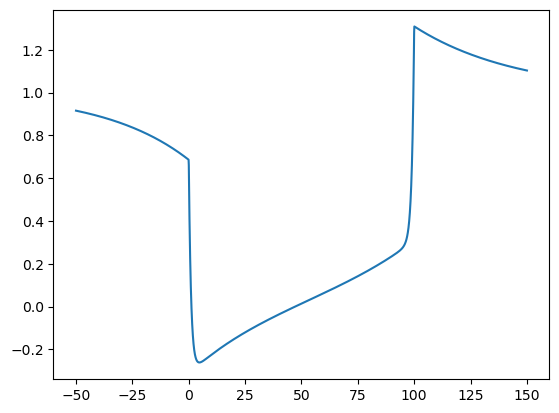

In [18]:
plt.plot(x_values, model.complex_potential(torch.tensor(x_values, device=device), 0).cpu().numpy())

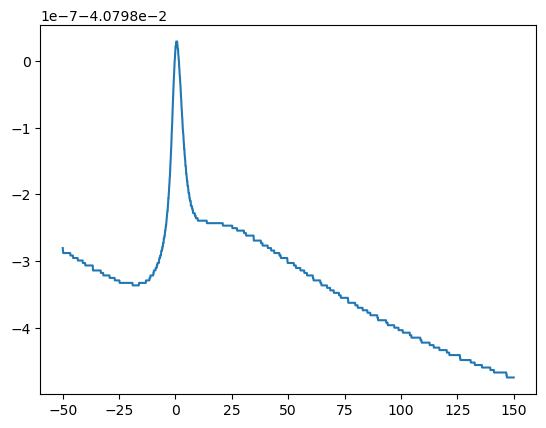

In [19]:
plt.plot(x_values, psi_real_pinn[:, 0])

In [20]:
# plt.figure(figsize=(8, 6), dpi=200)
# psi_sq_diff = np.abs(psi_sq_pinn - psi_sq_analytical)
# # view_metrics(psi_sq_diff)

# plt.pcolormesh(x_values, t_values, psi_sq_diff.transpose(), shading="auto")
# plt.colorbar(label='∆|psi(x,t)|^2')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Absolute error of |psi|^2')
# plt.show()

In [21]:
# diff_integrals = np.sqrt(psi_sq_diff).mean(axis=0) * (x_max - x_min)
# view_metrics(diff_integrals)

# plt.figure(figsize=(8,5), dpi=200)
# plt.plot(t_values, diff_integrals, '-')
# plt.xlabel('Time (ps)')
# plt.ylabel('Integral of absolute error of psi^2(x, t)')
# plt.title('Integral of sqrt(abs(delta(psi^2)))')
# plt.grid(True)
# plt.show()

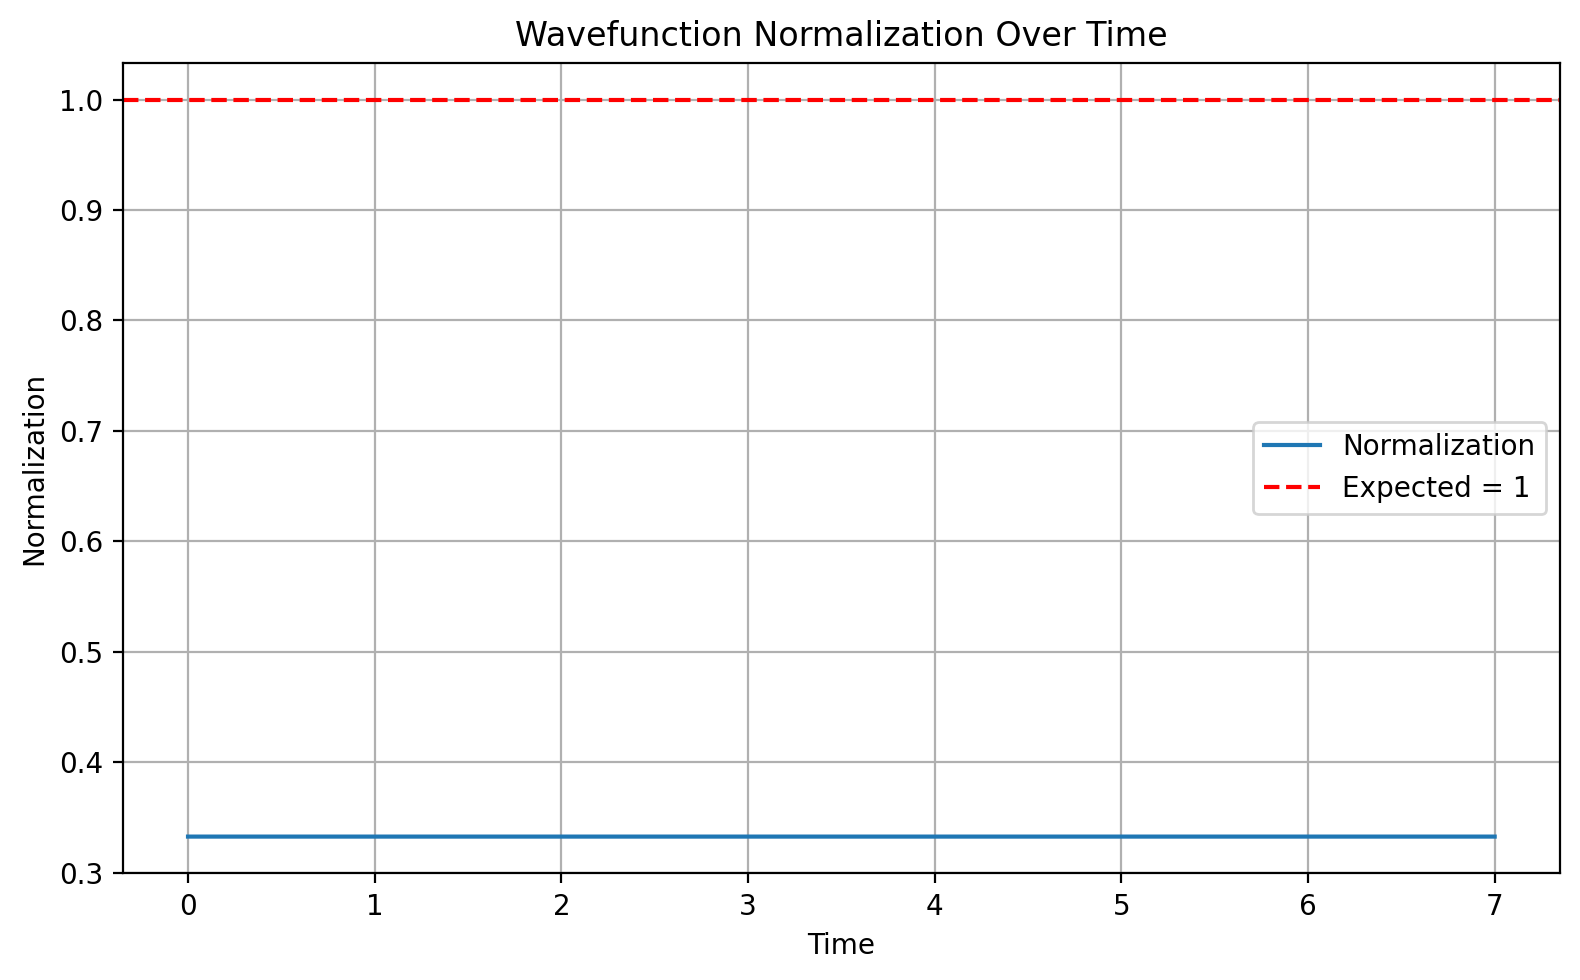

In [22]:
from scipy.integrate import simpson

norms = []

for i in range(2000):
    psi_sq_i = psi_real_pinn[:, i] ** 2 + psi_img_pinn[:, i] ** 2
    normalization = simpson(psi_sq_i, x=x_values)
    normalization_monte = np.mean(psi_sq_i) * (x_max - x_min)
    norms.append(normalization)
    
# view_metrics(np.array(norms))

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

ax.plot(t_values, norms, '-', label='Normalization')
ax.axhline(1.0, color='red', linestyle='--', label='Expected = 1')

ax.yaxis.get_major_formatter().set_useOffset(False)

ax.set_xlabel('Time')
ax.set_ylabel('Normalization')
ax.set_title('Wavefunction Normalization Over Time')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()